# graph_generator()


## IMPLEMENTACIÓN

  
Esta función se encarga de archivar las observaciones (.csv) importadas desde Netlogo por fecha y hora, a la vez que interpreta los datos de salida gráficamente. 
El procedimiento para su implementación es el siguiente:

1. Ejecutar el modelo en netlogo (uber.nlogo).
2. Al finalizar las simulaciones, se deberá ejecutar la función graph_generator() desde este notebook.
3. La función guardara las respectivas graficas en directorios clasificados por fecha y hora, con su respectiva transición(gif).



In [1]:
from PIL import *
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os
from apng import APNG
from IPython.display import Image
from os import walk
import time
import shutil
from shapely.geometry import shape
from shapely.ops import unary_union
import fiona
import networkx as nx
import itertools
import matplotlib.pyplot as plt
from IPython.core.debugger import Tracer
from shutil import copyfile

In [2]:
file_infofile_in  = fiona.open("../modules/csv/shp/Bogota_sencillo/New_Shapefile.shp")

y = set()
x = set()
lengths = set()

nodes = set()
edges = set()
edges_prime = set()

nodes_norm = list()
edges_norm = set()

for line in file_infofile_in:
    for node in line['geometry']['coordinates']:
        nodes.add((round(node[0],3),round(node[1],3)))
        x.add(round(node[0],3))
        y.add(round(node[1],3))

nodes = list(nodes)

# Getting the max and min for x and y axis
x_max = max(x)
x_min = min(x)
y_max = max(y)
y_min = min(y)
df3 = pd.DataFrame(data=[[x_min,x_max,y_min,y_max]], columns=['x_min','x_max','y_min','y_max'])
df3.to_csv('../distributions/boundaries.csv', index=False)

# Normalizing

for node in nodes:
    node_norm = (nodes.index(node), [(node[0]-x_min)/(x_max-x_min),(node[1]-y_min)/(y_max-y_min)])
    nodes_norm.append(node_norm)
    
nodes_norm = [(item[0], [round(item[1][0],3), round(item[1][1],3)]) for item in nodes_norm]

for line in file_infofile_in:
    last_coord = None
    for coord in line['geometry']['coordinates']:
        if last_coord != None:
            length = ((coord[0]-last_coord[0])**2+(coord[1]-last_coord[1])**2)**0.5
            edge = ((nodes.index((round(last_coord[0],3),round(last_coord[1],3))),nodes.index((round(coord[0],3),round(coord[1],3)))),length,line['properties']['Id'])
            edges.add(edge)
        last_coord = coord
        
    
edges = [edge for edge in edges if edge[0][1] != edge[0][0]]

length_max = max(list(zip(*edges))[1])
length_min = min(list(zip(*edges))[1])

# normalizing length
edges_norm = [(edges.index(edge),edge[0],(edge[1]-length_min)/(length_max-length_min),edge[2]) for edge in edges]

coords = []

for coord in list(zip(*edges))[0]:
    coord1 = (nodes[coord[0]], nodes[coord[1]])
    coords.append(coord1)


In [3]:
print(x_max) 
print(x_min) 
print(y_max) 
print(y_min) 

608838.592
587043.869
10525675.608
10499872.47


In [8]:
def graph_generator():
    
    #PRIMEROS DATOS EXPORTADOS 
    outs_files = os.listdir('.')
    old_dir = [i for i in outs_files if "." not in i]
    csvs = [i for i in outs_files if ".csv" in i]
    csvs

    folders = [file[:23] for file in csvs]
    folders = set(folders)
    
    #CLASIFICANDOLOS Y MOVIENDOLOS 
    for folder in folders:
        os.makedirs(str(folder+'/people/gif'))
        os.makedirs(str(folder+ '/drivers/gif'))                
        for csv in csvs:
            if folder in csv:
                shutil.move(csv, folder)

    
    listdir1 = os.listdir('.')
    listdir2 = [i for i in listdir1 if "___" in i]
    for n in old_dir:    
        listdir2.remove(str(n))
        listdir2
    listdir2

    for dirr in listdir2:

        outs_files1 = os.listdir('./' + dirr)
        csvs1 = [i for i in outs_files1 if "_.csv" in i]
        csvs1


        for csv1 in csvs1:

            d = pd.read_csv(dirr+'/'+csv1, error_bad_lines=False)
            df = pd.DataFrame(data=d)
            df2 = df[df['breed'] == 'people']
            df3 = df[df['breed'] == 'drivers']

         #GENERANDO GRAFICAS Y GUARDANDOLAS EN DIRECTORIO  
            #people
            plot = sns.jointplot(x="x", y="y", data=df2, kind = 'kde', size=10, xlim=(-5,40), ylim=(-5,40), color='r')
            for i in coords:
    
                plot.ax_joint.plot([(((coords[coords.index(i)][0][0])-x_min)/(x_max-x_min))*30,(((coords[coords.index(i)][1][0])-x_min)/(x_max-x_min))*30],[(((coords[coords.index(i)][0][1])-y_min)/(y_max-y_min))*30,(((coords[coords.index(i)][1][1])-y_min)/(y_max-y_min))*30],'black')
            #import ipdb; ipdb.set_trace()
            plt.savefig(plt.savefig(str(dirr+'/people/people' + '_' + str(csvs1.index(csv1)) + '.png')))
            #drivers 
            plot = sns.jointplot(x="x", y="y", data=df3, kind = 'kde', size=10, xlim=(-5,40), ylim=(-5,40), color='r')
            for i in coords:
    
                plot.ax_joint.plot([(((coords[coords.index(i)][0][0])-x_min)/(x_max-x_min))*30,(((coords[coords.index(i)][1][0])-x_min)/(x_max-x_min))*30],[(((coords[coords.index(i)][0][1])-y_min)/(y_max-y_min))*30,(((coords[coords.index(i)][1][1])-y_min)/(y_max-y_min))*30],'black')

            plt.savefig(plt.savefig(str(dirr+'/drivers/drivers' + '_' + str(csvs1.index(csv1)) + '.png')))

    #ANIMACIÓN

        groups = ['df2','df3']
        for n in groups:
            #people
            if groups[groups.index(n)] == 'df2':

                def ls(ruta = str(dirr+'/people')):

                    return next(walk(ruta))[2]

                images_people = ls()
                images_people


                for m in images_people:                           
                    img = str(str(dirr +'/people/' + m))      
                    img
                    graphs = images_people
                    graphs[int(images_people.index(m))] = img                        

                APNG.from_files(graphs, delay = 400).save(str(dirr+'/people/gif/trans_p_'+dirr+'.png'))
                Image(filename = str(dirr+'/people/gif/trans_p_'+dirr+'.png'))
            #drivers
            elif groups[groups.index(n)] == 'df3':

                def ls(ruta = str(dirr+'/drivers')):

                    return next(walk(ruta))[2]

                images_drivers = ls()
                images_drivers


                for x in images_drivers: 

                    immg = str(str(dirr +'/drivers/' + x))       
                    immg
                    graphs = images_drivers
                    graphs[int(images_drivers.index(x))] = immg                        

                APNG.from_files(graphs,delay=400).save(str(dirr+'/drivers/gif/trans_d_'+dirr+'.png'))
                Image(filename=str(dirr+'/drivers/gif/trans_d_'+dirr+'.png'))



C:\Users\danpa\Anaconda3\lib\site-packages\matplotlib\pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


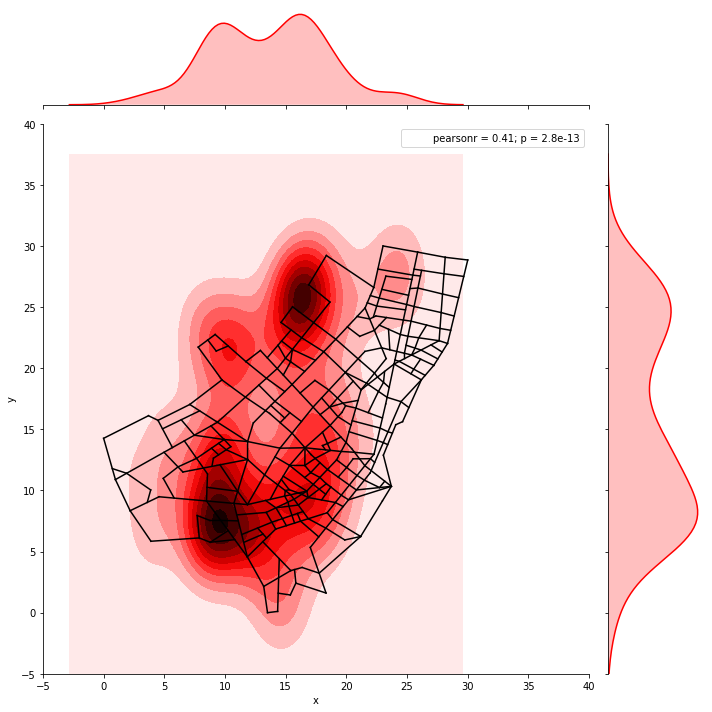

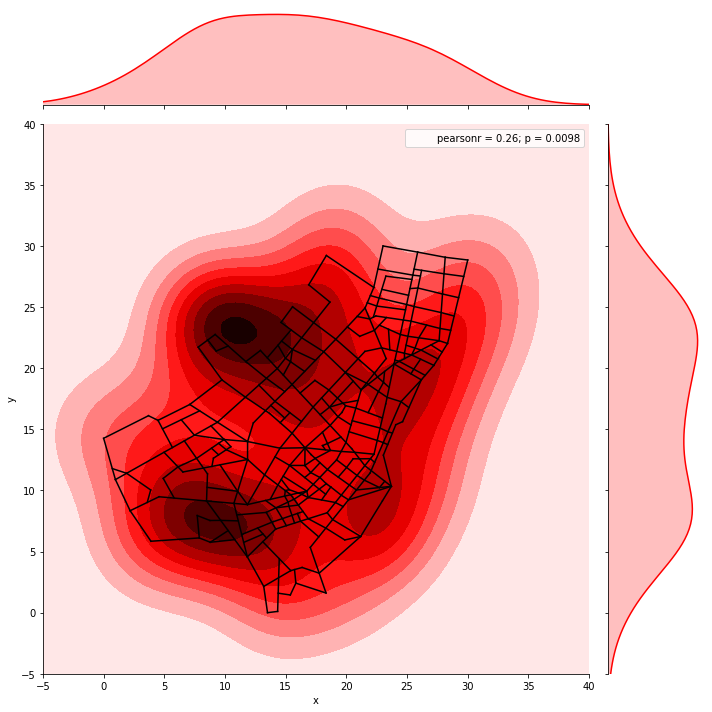

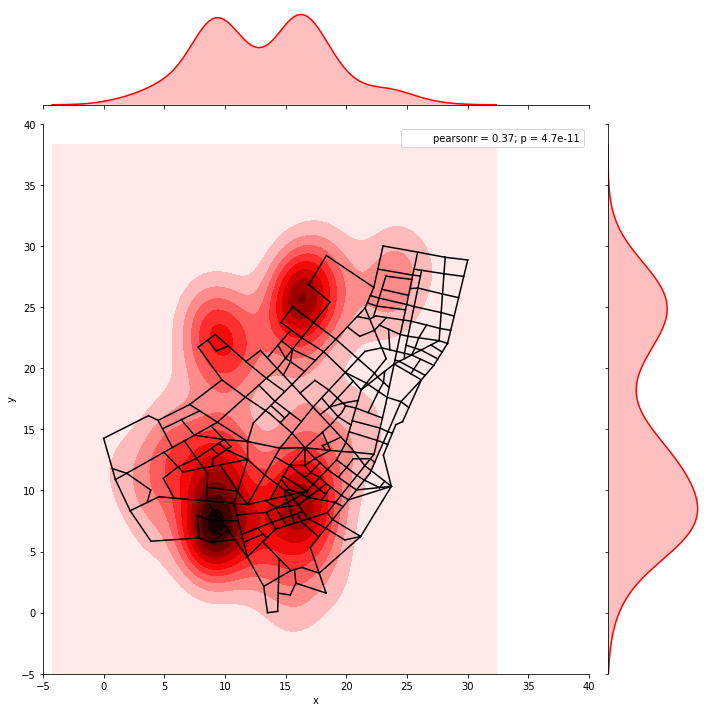

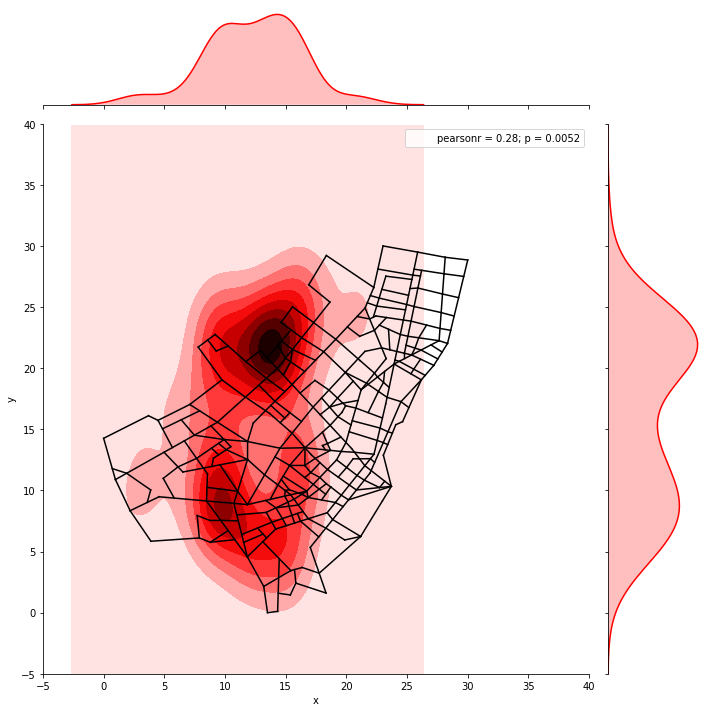

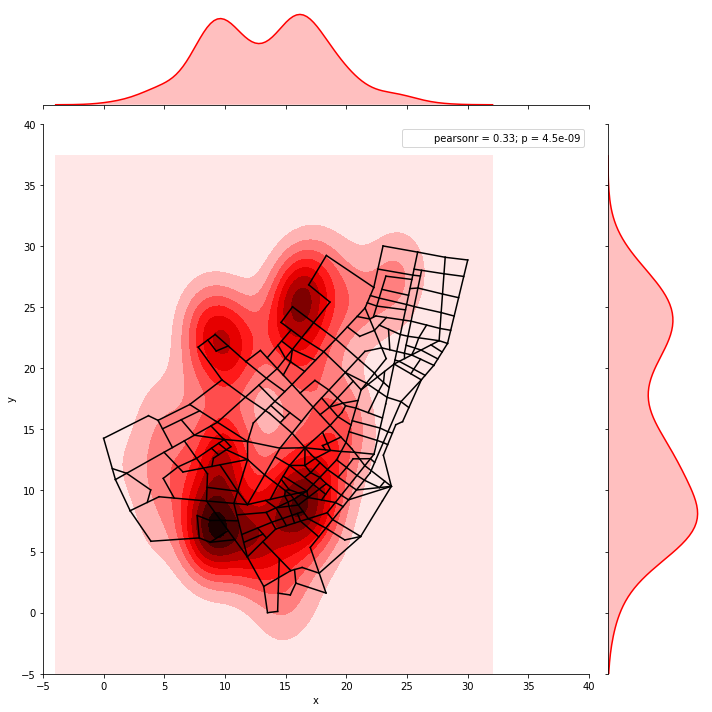

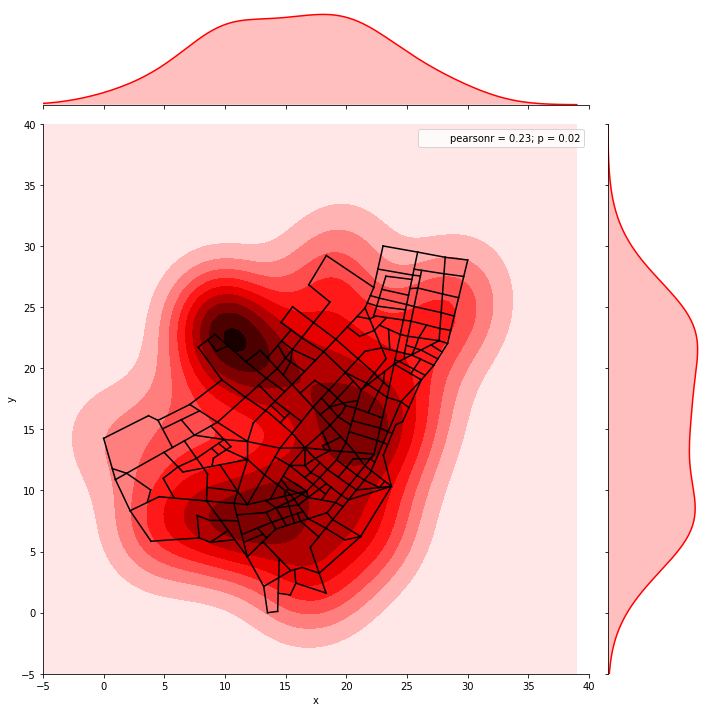

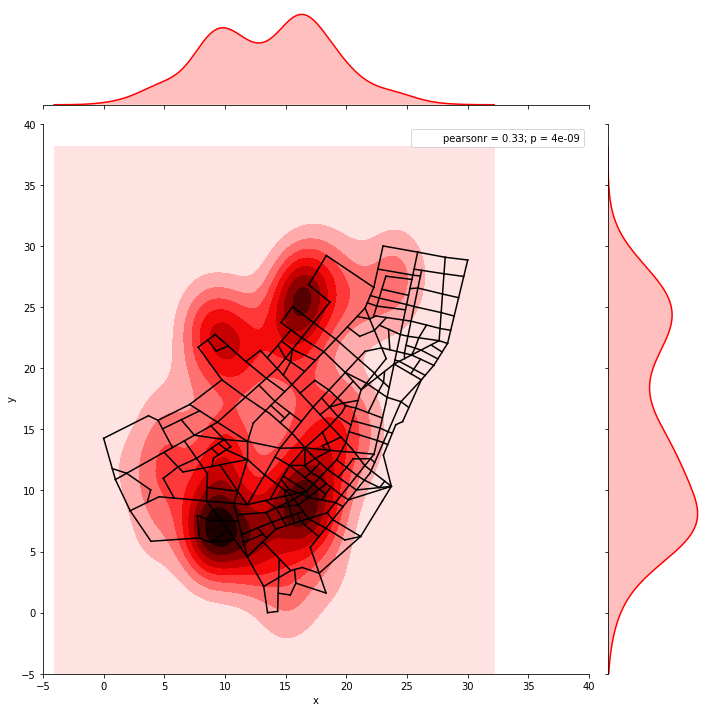

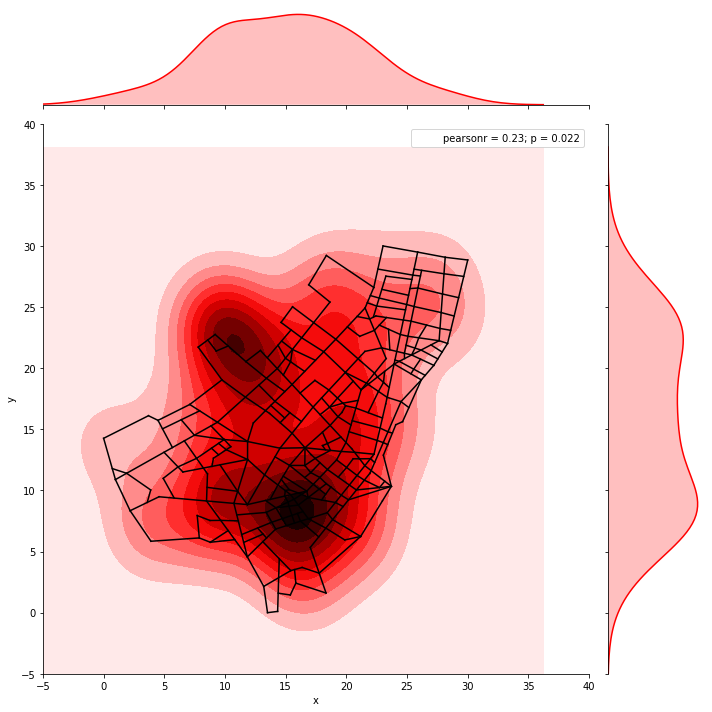

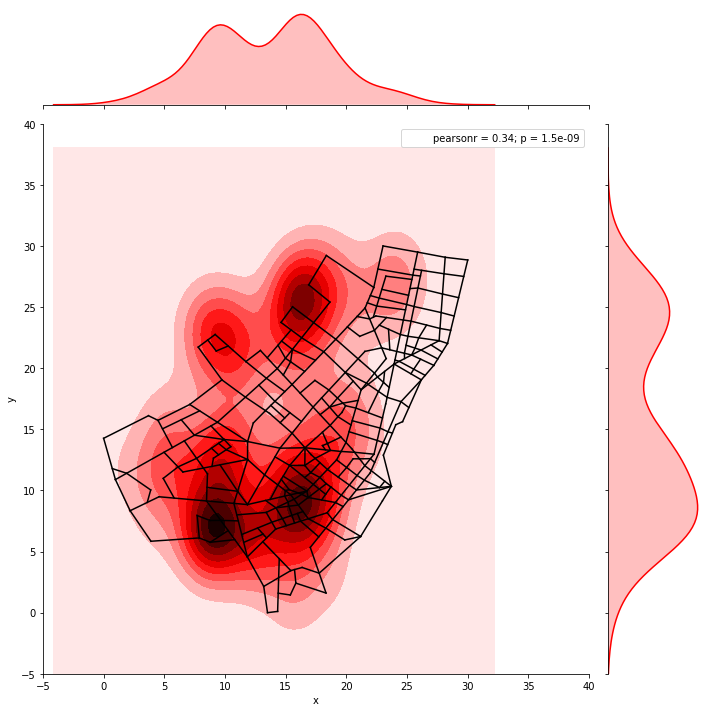

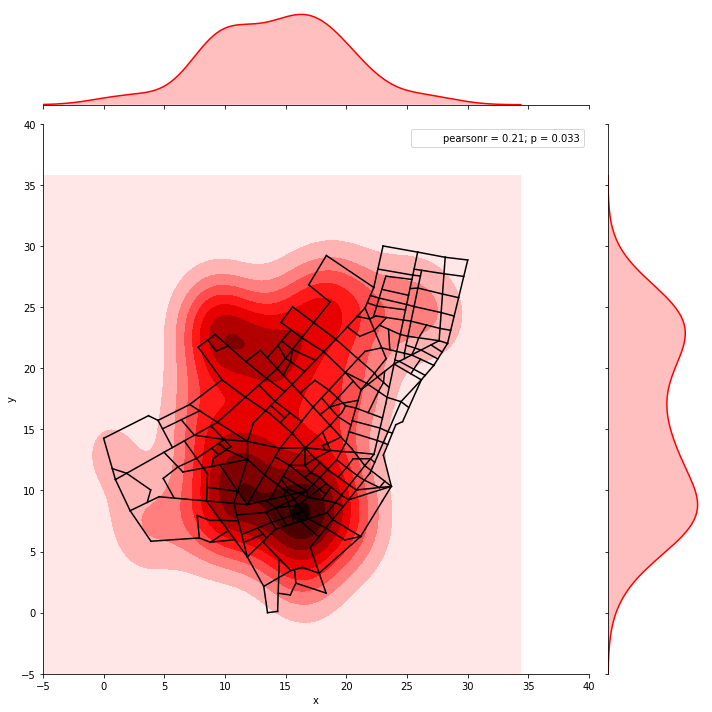

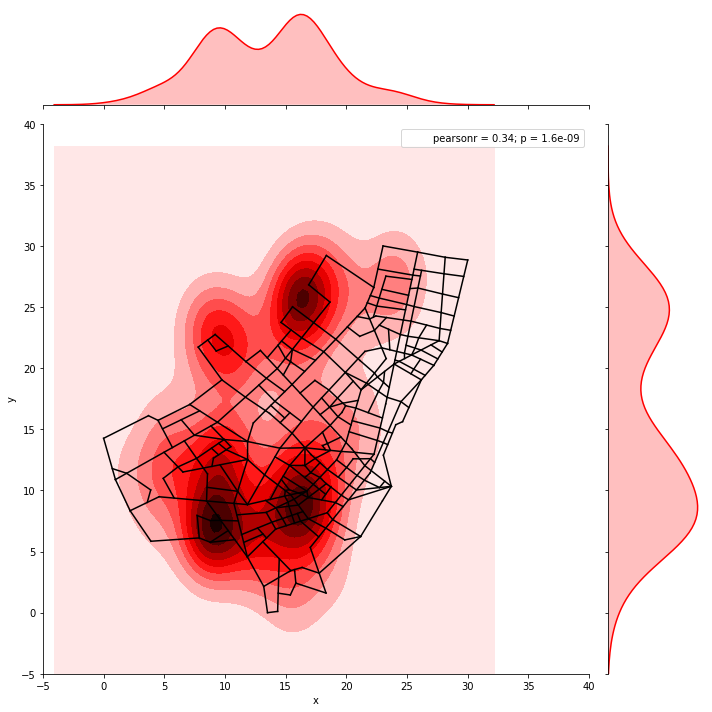

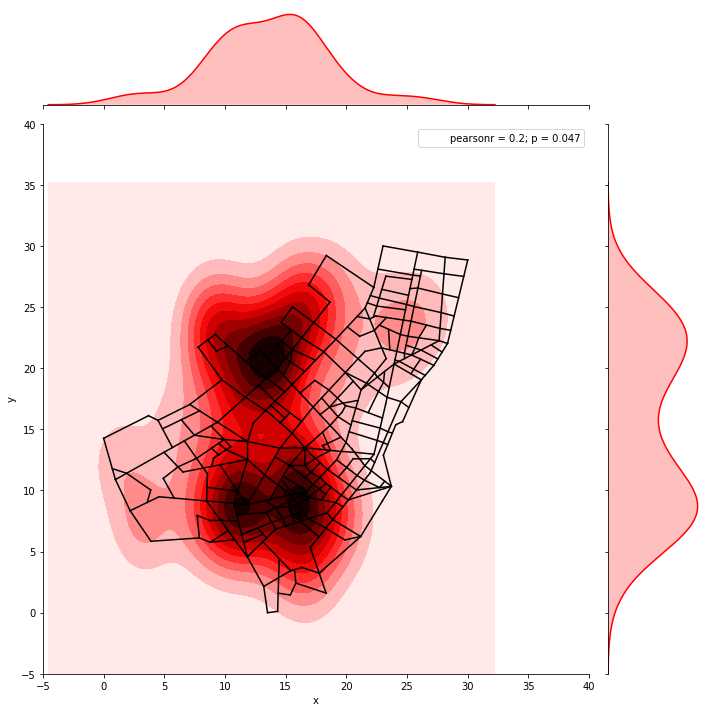

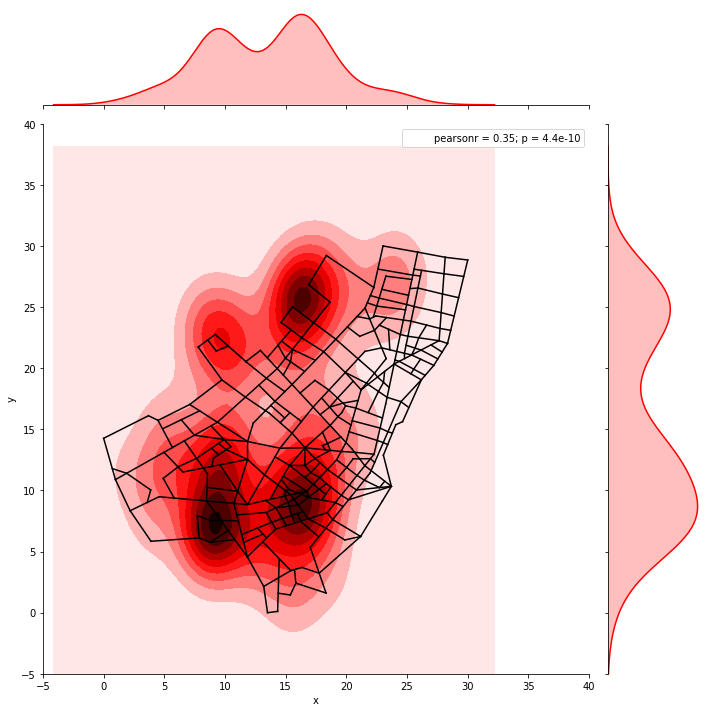

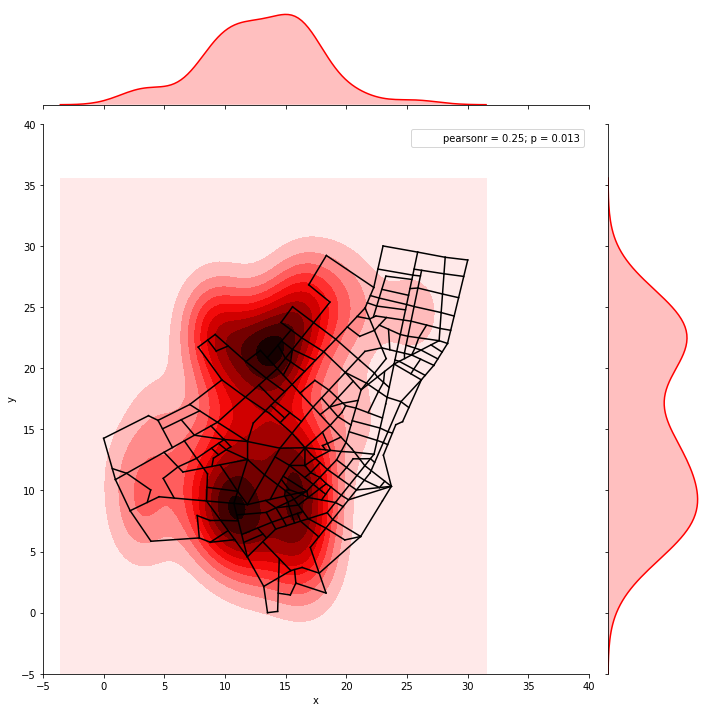

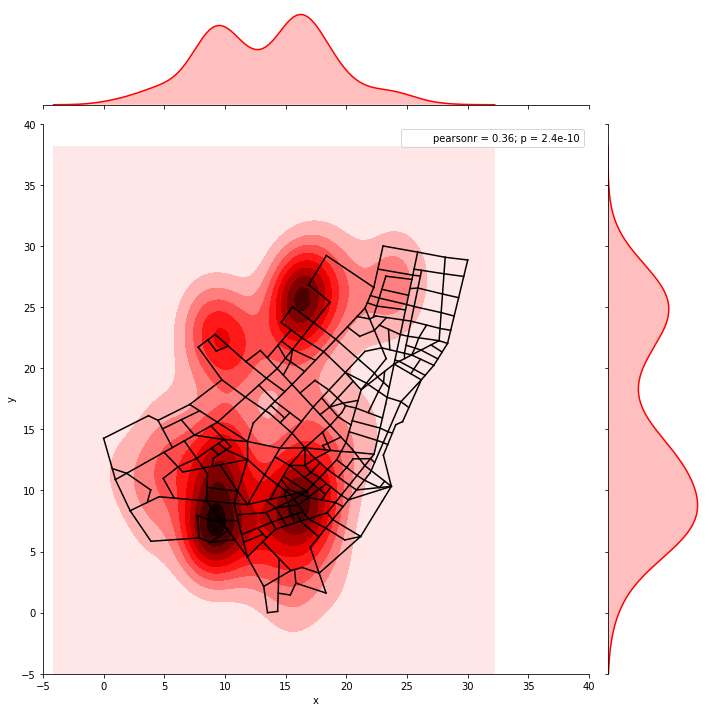

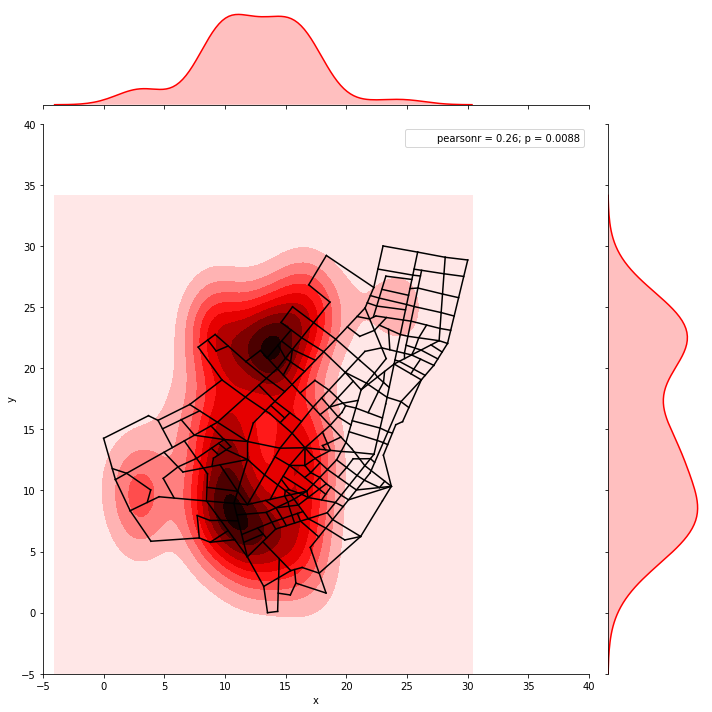

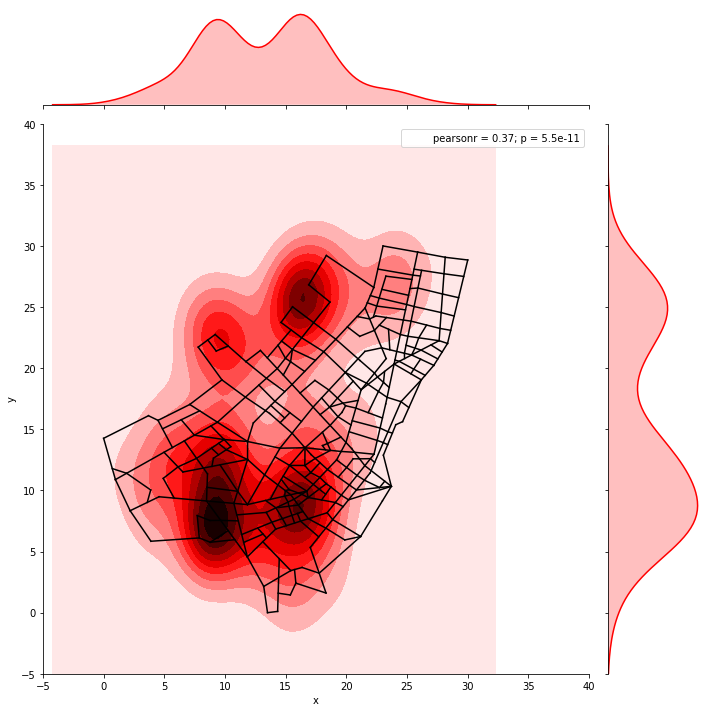

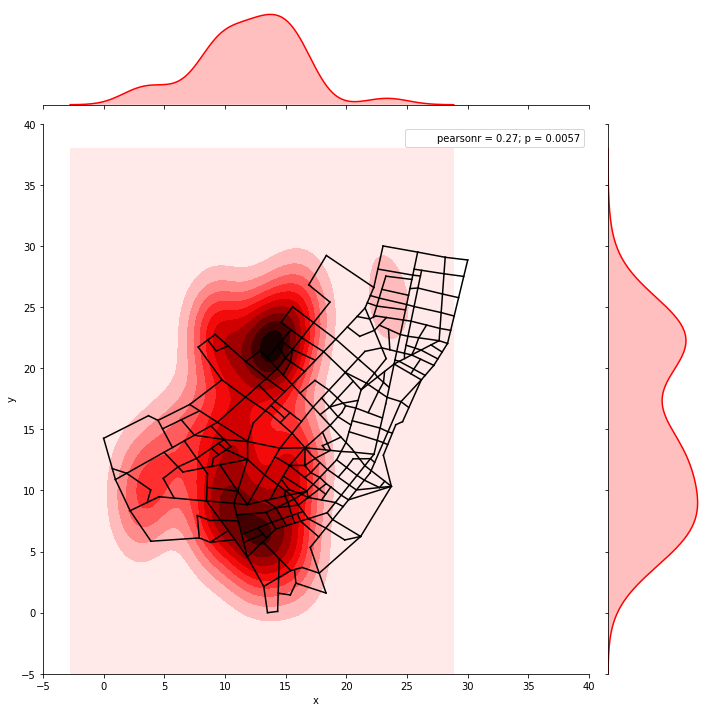

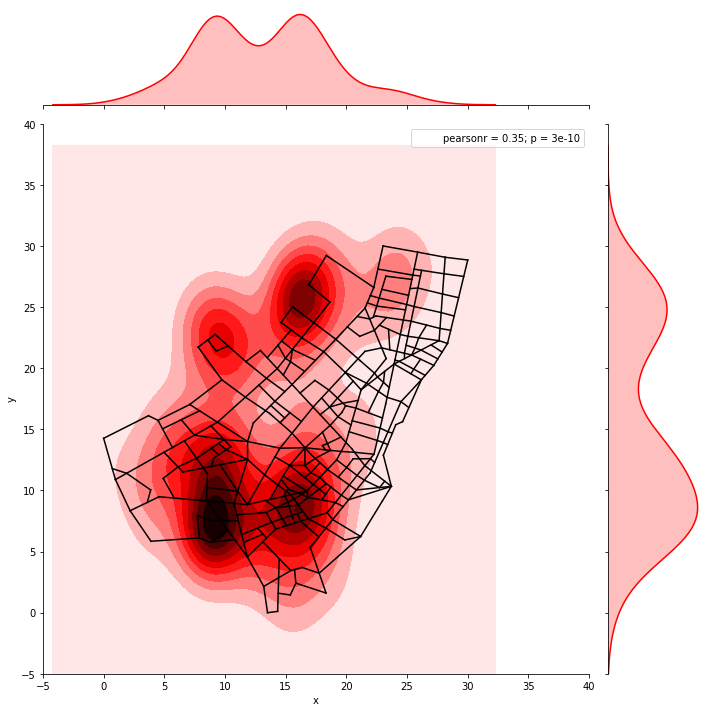

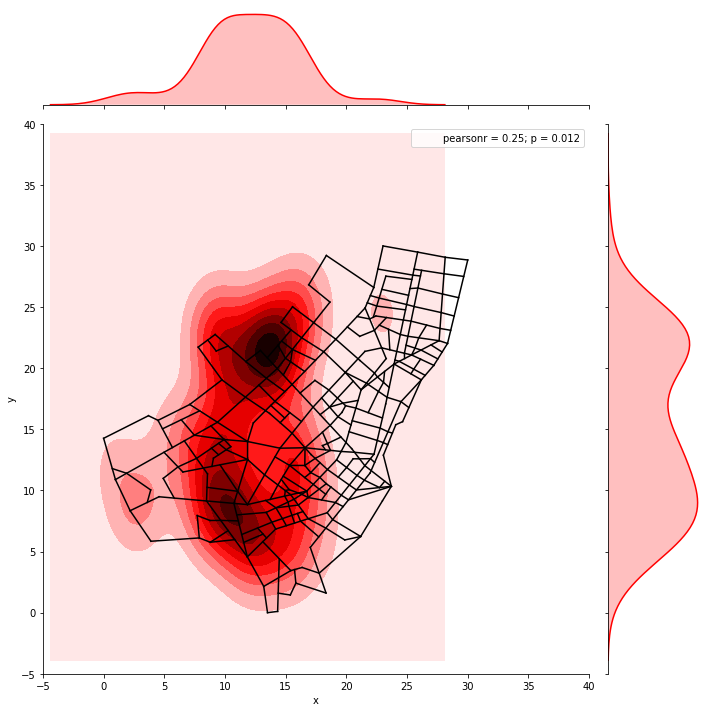

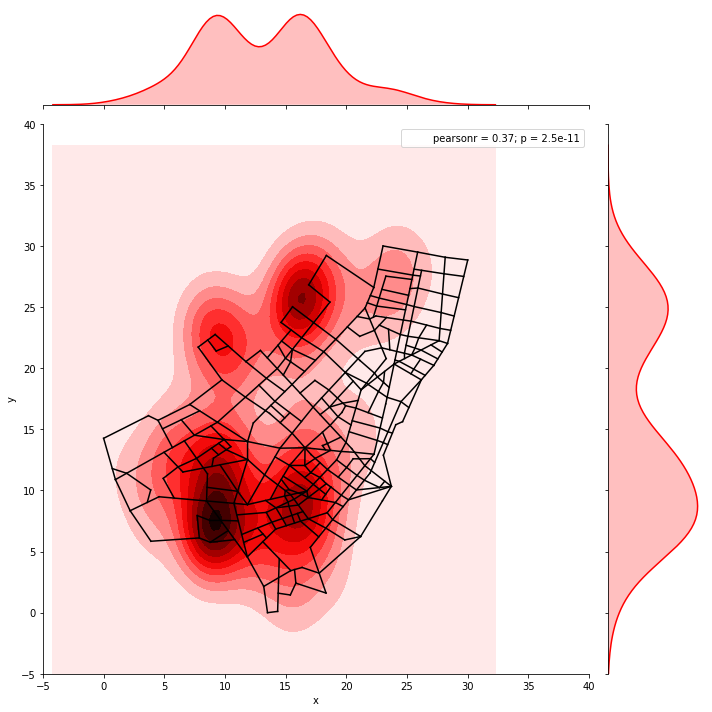

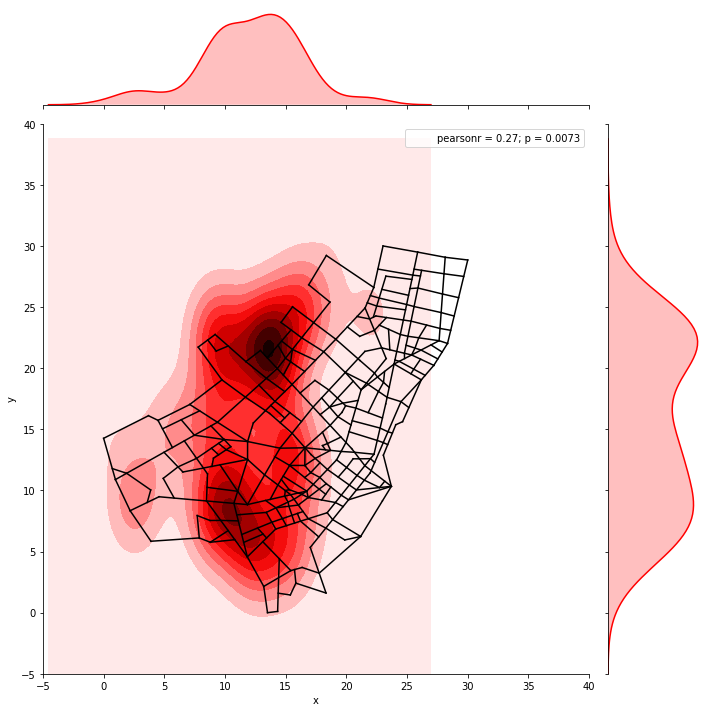

In [9]:
graph_generator()